# Missing Imputation 
Using Pandas, Numpy, and sklearn

In [178]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.linear_model import LassoLarsCV

### Load Data

In [135]:
beijing = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv")
beijing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


### Data Transformations

In [136]:
dropvars = ['No']
target = 'pm2.5'

In [137]:
is_target_missing = beijing[target].isnull()

#### Convert Categorical to Numeric Using Dummies

In [138]:
beijing = pd.get_dummies(beijing,columns=['year','month','day','hour','cbwd'], drop_first=True)

In [139]:
beijing.drop(var_type['del'],axis=1,inplace=True)

In [144]:
X_pred = beijing.loc[is_target_missing].drop(target,axis=1).values
X_true = beijing.loc[~is_target_missing].drop(target,axis=1).values

In [145]:
y = beijing.loc[~is_target_missing,target].values.astype('int32')

#### Scale Predictors to Improve Estimation Efficiency

In [168]:
scaler = RobustScaler()
X_true = scaler.fit_transform(X_true)
X_pred = scaler.transform(X_pred)

In [170]:
cv = KFold(n_splits=5, shuffle=True, random_state=2019)

## Model Selection
### Random Forest

In [203]:
rf = RandomForestRegressor(n_estimators=50,max_depth=15,min_samples_leaf=30,random_state=19)

In [204]:
oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    rf.fit(X_true[train], y[train])
    ypred = rf.predict(X_true[test])
    oof[test] = ypred

In [205]:
print("msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

msle 0.43419 R-square 0.5674


### Lasso - Lars Regression
Uses Log Transformation of Dependent Variable

In [212]:
reg = LassoLarsCV(cv=10).fit(X_true, np.log1p(y))
oof = np.expm1(reg.predict(X_true))
print("msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

msle 0.46569 R-square 0.3530


### Gradient Boosting Regression
#### BEST FIT (R-square 0.7931)

In [252]:
#gb = GradientBoostingRegressor(n_estimators = 150, max_depth = 12) ### Best Parameters with Log Transform
#gb = GradientBoostingRegressor(n_estimators = 200, max_depth = 10) ### Best Parameters with No Transform
gb = GradientBoostingRegressor(n_estimators = 200, max_depth = 10)

In [253]:
oof = np.zeros(y.shape[0])
for train, test in cv.split(X_true,y):
    #gb.fit(X_true[train], np.log1p(y[train]))
    #ypred = np.expm1(gb.predict(X_true[test]))
    gb.fit(X_true[train], y[train])
    ypred = np.maximum(gb.predict(X_true[test]),0)
    oof[test] = ypred

In [254]:
print(#"msle {:.5f}".format(mean_squared_log_error(y,oof))+
      " R-square {:.4f}".format(r2_score(y,oof)))

 R-square 0.8045


## Prediction of Missing Values

In [255]:
new_y = np.zeros(beijing.shape[0])
new_y[~is_target_missing] = y
new_y[is_target_missing] = gb.predict(X_pred)

In [256]:
beijing = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv")
beijing['model_pm2.5'] = new_y
beijing.to_csv("beijing.csv")

### Verify Qualitative Behavior of Modeled Dependent Variable

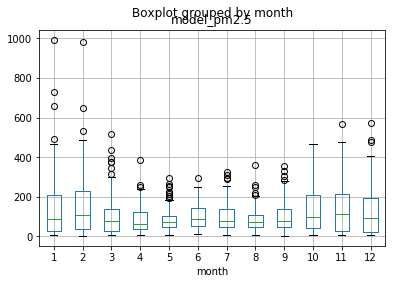

In [257]:
ax = beijing.loc[beijing.hour==1].boxplot("model_pm2.5",by="month")

In [258]:
grouped = beijing.groupby(["month","cbwd"])["model_pm2.5"].median().unstack()
grouped.style.format("{:.1f}").highlight_max(axis=1,color="royalblue").\
set_caption("Max Median by Month and Wind Direction")

cbwd,NE,NW,SE,cv
month,,,,
1,41.5,30.0,119.5,128.0
2,36.0,41.0,103.0,133.5
3,42.0,23.0,93.0,118.0
4,56.0,24.0,91.0,84.0
5,65.6,38.0,82.0,79.0
6,58.0,38.5,96.1,88.0
7,58.5,35.0,92.5,83.5
8,67.0,36.0,80.0,82.0
9,52.0,34.0,84.0,84.0
